# 《人工智能导论》期末大作业
## 毛千辰_18071220
## 沈崔枫_17071134

# 数据处理
- 我们使用的数据集为：BDD100K，关于该数据集的具体说明可以查看 --> [BDD100K](moz-extension://4628f372-db2e-41ac-bda3-fa69758703b8/assets/pdf/web/viewer.html?file=https%3A%2F%2Farxiv.org%2Fpdf%2F1805.04687.pdf)
- 使用的框架为Pytorch，IDE环境为windows下的juypter notebook


*数据集处理方式：BDD100K官方并没有对该数据集作出使用的说明，也没有提供一个很好的接口，所以关于数据集我们需要自己进行处理。在[BDD100K官方github中的label文件](https://github.com/ucbdrive/bdd100k/blob/master/bdd100k/label.py)中，官方给出了namedtuple封装的各个类，我们使用里面的trainId进行图标分割的像素值匹配，配合文档中的train文件夹使用，具体可以见代码。*

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
#数据集位置：我放在D盘中
DATA_DIR = 'D:\\BDD100K\\seg'
if not os.path.exists(DATA_DIR):
    print('Can\'t find dataset!')

In [3]:

x_train_dir = os.path.join(DATA_DIR, 'images\\train')
y_train_dir = os.path.join(DATA_DIR, 'labels\\train')

x_valid_dir = os.path.join(DATA_DIR, 'images\\val')
y_valid_dir = os.path.join(DATA_DIR, 'labels\\val')


x_test_dir = os.path.join(DATA_DIR, 'images\\test')
#y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
# 可视化图片
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [6]:
from collections import namedtuple
# 此处为官方github给的label.py，用来帮助我们提取类别信息
# from : https://github.com/ucbdrive/bdd100k/blob/master/bdd100k/label.py
Label = namedtuple('Label', [

    'name',  # The identifier of this label, e.g. 'car', 'person', ... .
    # We use them to uniquely name a class

    'id',  # An integer ID that is associated with this label.
    # The IDs are used to represent the label in ground truth images
    # An ID of -1 means that this label does not have an ID and thus
    # is ignored when creating ground truth images (e.g. license plate).
    # Do not modify these IDs, since exactly these IDs are expected by the
    # evaluation server.

    'trainId',
    # Feel free to modify these IDs as suitable for your method. Then create
    # ground truth images with train IDs, using the tools provided in the
    # 'preparation' folder. However, make sure to validate or submit results
    # to our evaluation server using the regular IDs above!
    # For trainIds, multiple labels might have the same ID. Then, these labels
    # are mapped to the same class in the ground truth images. For the inverse
    # mapping, we use the label that is defined first in the list below.
    # For example, mapping all void-type classes to the same ID in training,
    # might make sense for some approaches.
    # Max value is 255!

    'category',  # The name of the category that this label belongs to

    'categoryId',
    # The ID of this category. Used to create ground truth images
    # on category level.

    'hasInstances',
    # Whether this label distinguishes between single instances or not

    'ignoreInEval',
    # Whether pixels having this class as ground truth label are ignored
    # during evaluations or not

    'color',  # The color of this label
])
labels = [
    #       name                     id    trainId   category catId      hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  1 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ego vehicle'          ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ground'               ,  3 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'parking'              ,  5 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           ,  6 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'bridge'               ,  9 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'building'             , 10 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'fence'                , 11 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'garage'               , 12 ,      255 , 'construction'    , 2       , False        , True         , (180,100,180) ),
    Label(  'guard rail'           , 13 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'tunnel'               , 14 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'wall'                 , 15 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'banner'               , 16 ,      255 , 'object'          , 3       , False        , True         , (250,170,100) ),
    Label(  'billboard'            , 17 ,      255 , 'object'          , 3       , False        , True         , (220,220,250) ),
    Label(  'lane divider'         , 18 ,      255 , 'object'          , 3       , False        , True         , (255, 165, 0) ),
    Label(  'parking sign'         , 19 ,      255 , 'object'          , 3       , False        , False        , (220, 20, 60) ),
    Label(  'pole'                 , 20 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 21 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'street light'         , 22 ,      255 , 'object'          , 3       , False        , True         , (220,220,100) ),
    Label(  'traffic cone'         , 23 ,      255 , 'object'          , 3       , False        , True         , (255, 70,  0) ),
    Label(  'traffic device'       , 24 ,      255 , 'object'          , 3       , False        , True         , (220,220,220) ),
    Label(  'traffic light'        , 25 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 26 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'traffic sign frame'   , 27 ,      255 , 'object'          , 3       , False        , True         , (250,170,250) ),
    Label(  'terrain'              , 28 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'vegetation'           , 29 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'sky'                  , 30 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 31 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 32 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'bus'                  , 34 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'car'                  , 35 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'caravan'              , 36 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'motorcycle'           , 37 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'trailer'              , 38 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 39 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'truck'                , 40 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
]

In [7]:
CLASSES_ALL=['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car' ,'truck' , 'bus', 'train', 'motorcycle', 'bicycle']

# 整理类别信息
import numpy as np
CLASSES=[]
CLASSES_VALUE=[]
for label in labels:
    if(label.trainId != 255):
        CLASSES.append(label.name)
        CLASSES_VALUE.append(label.trainId)
CLASSES_sorted=np.array(CLASSES)
CLASSES_VALUE=np.array(CLASSES_VALUE)
CLASSES_sorted=CLASSES_sorted[CLASSES_VALUE]
CLASSES_sorted=list(CLASSES_sorted)
print(CLASSES_sorted)
# 但似乎索引排序有问题，需要手动修正

['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'truck', 'car', 'bicycle', 'train', 'motorcycle', 'bus']


In [8]:
#数据集类的定义
class Dataset(BaseDataset):
    
    CLASSES=['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car' ,'truck' , 'bus', 'train', 'motorcycle', 'bicycle','unlabeled']

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.idss=[idx[0:17]+'_train_id.png' for idx in self.ids]
        #print(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        #print(self.images_fps)
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.idss]
        #print(self.masks_fps)
        
        # convert str names to class values on masks
        values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values=[]
        for x in values:
            if x!=19:
                self.class_values.append(x)
            else:
                self.class_values.append(255)
        #print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        #print(masks)
        #print(mask.shape)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

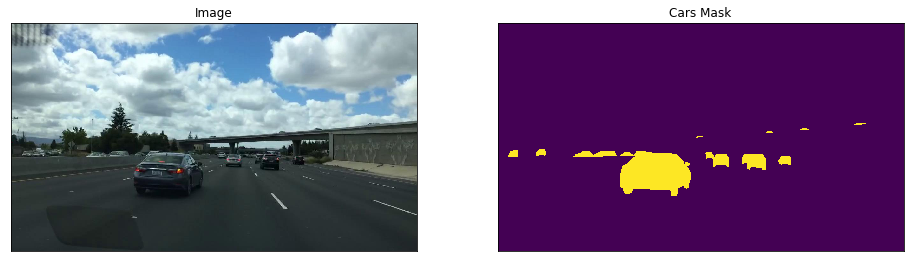

In [9]:
# peek一下随意一张的类别
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(-1),
)

# 数据增强

- 本版本主要是测试albu.CropNonEmptyMaskIfExists的用处，为了解决之前发现的样本问题。目前看来，之前分析的原因是正确的，效果拔群！！！

In [10]:
import albumentations as albu

In [11]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.CropNonEmptyMaskIfExists(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320),
        #没有resize会报错
        #albu.Resize(height=320, width=320, always_apply=True)
        albu.CropNonEmptyMaskIfExists(height=320, width=320, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

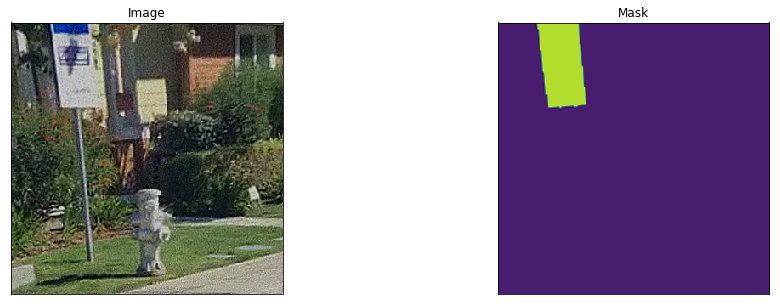

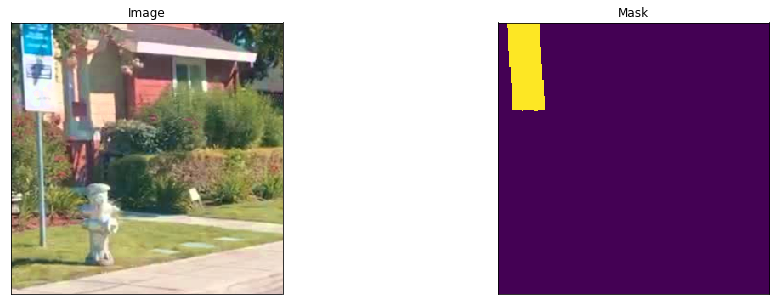

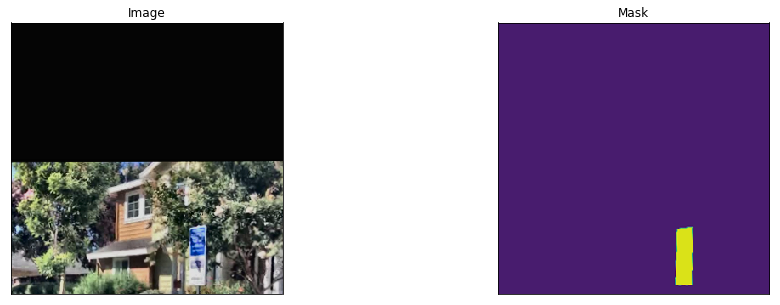

In [12]:
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['traffic sign'],
)


# 使用albu.CropNonEmptyMaskIfExists，因此mask会一直存在。
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

# 模型训练

- 由于选择的训练类别是小目标"traffic sign"，从而会有样本不均衡的问题，而且dice loss和MIOU指标本身也偏向于大目标，所以loss会很高。如果换成"road"会发现收敛的很快。
- 目前使用的模型为PSPNet,loss难收敛，指标上不去，有待训练观察。
- 之前已尝试:FPN+se_resnext50_32x4d、UNet+se_resnext50_32x4d、Unet+resnext50_32x4d、FPN+resnext50_32x4d。都有上面的问题。
- loss在训练集的表现反而不如验证集的个人猜想: 由于RandomCrop，导致许多训练集上没有样本，此时loss为1，当折合进入到一个epoch的loss时，会使得loss反而增大。
- 新增了albu.CropNonEmptyMaskIfExists方法(见数据增强处)，效果拔群！！！

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [14]:
ENCODER = 'se_resnext50_32x4d'# se_resnext50_32x4d 和 resnext50_32x4d
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['traffic sign'] #traffic light
ACTIVATION = 'sigmoid' #  'softmax2d' for multicalss segmentation 'sigmoid' for one
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [15]:


train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)# 0 for [Errno 32] Broken pipe
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)



In [16]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [17]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [18]:
# train model for 40 epochs

max_score = 0

for i in range(0, 80):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_aug3.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|███████████████████████████████| 1000/1000 [02:11<00:00,  8.04it/s, dice_loss - 0.6647, iou_score - 0.4497]
Model saved!

Epoch: 1
valid: 100%|███████████████████████████████| 1000/1000 [01:44<00:00,  9.69it/s, dice_loss - 0.6194, iou_score - 0.4569]
Model saved!

Epoch: 2
valid: 100%|███████████████████████████████| 1000/1000 [02:07<00:00,  7.82it/s, dice_loss - 0.5805, iou_score - 0.4679]
Model saved!

Epoch: 3
valid: 100%|███████████████████████████████| 1000/1000 [01:43<00:00,  9.87it/s, dice_loss - 0.5647, iou_score - 0.4776]
Model saved!

Epoch: 4
valid: 100%|███████████████████████████████| 1000/1000 [02:07<00:00,  7.54it/s, dice_loss - 0.5464, iou_score - 0.5064]
Model saved!

Epoch: 5
valid: 100%|███████████████████████████████| 1000/1000 [01:44<00:00,  9.60it/s, dice_loss - 0.5301, iou_score - 0.5002]

Epoch: 6
valid: 100%|███████████████████████████████| 1000/1000 [02:08<00:00,  7.96it/s, dice_loss - 0.5003, iou_score - 0.5054]

Epoch: 7
valid: 100%|███

valid: 100%|███████████████████████████████| 1000/1000 [03:06<00:00,  5.75it/s, dice_loss - 0.3929, iou_score - 0.5483]

Epoch: 32
valid: 100%|███████████████████████████████| 1000/1000 [03:07<00:00,  5.65it/s, dice_loss - 0.3747, iou_score - 0.5662]
Model saved!

Epoch: 33
valid: 100%|███████████████████████████████| 1000/1000 [03:05<00:00,  5.75it/s, dice_loss - 0.3979, iou_score - 0.5424]

Epoch: 34
valid: 100%|███████████████████████████████| 1000/1000 [03:06<00:00,  5.70it/s, dice_loss - 0.3789, iou_score - 0.5585]

Epoch: 35
valid: 100%|███████████████████████████████| 1000/1000 [03:05<00:00,  5.51it/s, dice_loss - 0.4023, iou_score - 0.5335]

Epoch: 36
valid: 100%|███████████████████████████████| 1000/1000 [03:12<00:00,  5.59it/s, dice_loss - 0.3891, iou_score - 0.5529]

Epoch: 37
valid: 100%|███████████████████████████████| 1000/1000 [03:11<00:00,  5.62it/s, dice_loss - 0.3686, iou_score - 0.5736]
Model saved!

Epoch: 38
valid: 100%|████████████████████████████████| 1000/1000 [

KeyboardInterrupt: 

In [20]:
max_score = 0.5577

for i in range(61, 80):
    
    optimizer.param_groups[0]['lr'] = 1e-6
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_aug3.pth')
        print('Model saved!')


Epoch: 61
valid: 100%|███████████████████████████████| 1000/1000 [03:05<00:00,  5.66it/s, dice_loss - 0.3671, iou_score - 0.5692]
Model saved!

Epoch: 62
valid: 100%|███████████████████████████████| 1000/1000 [03:34<00:00,  5.11it/s, dice_loss - 0.3575, iou_score - 0.5824]
Model saved!

Epoch: 63
valid: 100%|███████████████████████████████| 1000/1000 [06:25<00:00,  1.70it/s, dice_loss - 0.3746, iou_score - 0.5618]

Epoch: 64
valid: 100%|███████████████████████████████| 1000/1000 [03:43<00:00,  4.60it/s, dice_loss - 0.3755, iou_score - 0.5655]

Epoch: 65
valid: 100%|███████████████████████████████| 1000/1000 [03:06<00:00,  5.49it/s, dice_loss - 0.3719, iou_score - 0.5646]

Epoch: 66
valid: 100%|███████████████████████████████| 1000/1000 [03:15<00:00,  5.38it/s, dice_loss - 0.3542, iou_score - 0.5846]
Model saved!

Epoch: 67
valid: 100%|███████████████████████████████| 1000/1000 [03:18<00:00,  5.73it/s, dice_loss - 0.3758, iou_score - 0.5627]

Epoch: 68
valid: 100%|█████████████████████

In [21]:
# load best saved checkpoint
best_model = torch.load('./best_model_aug3.pth')

In [22]:
# create test dataset
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['traffic sign'],
)

test_dataloader = DataLoader(test_dataset)



In [23]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|███████████████████████████████| 1000/1000 [03:33<00:00,  5.32it/s, dice_loss - 0.3567, iou_score - 0.5797]


In [24]:


# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_valid_dir, 
    y_valid_dir,
    classes=['traffic sign'],
    augmentation=get_validation_augmentation(), 
)



(320, 320)
(320,)


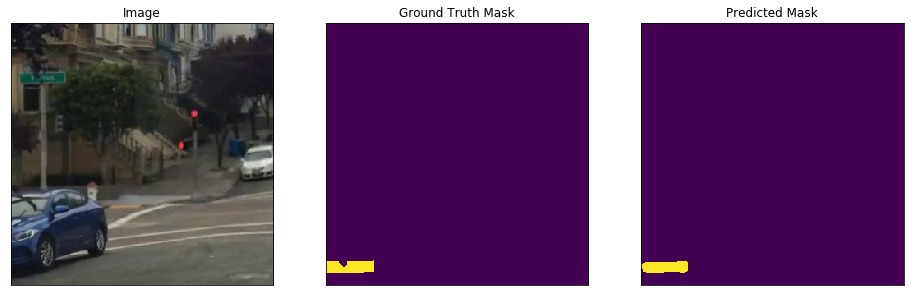

(320, 320)
(320,)


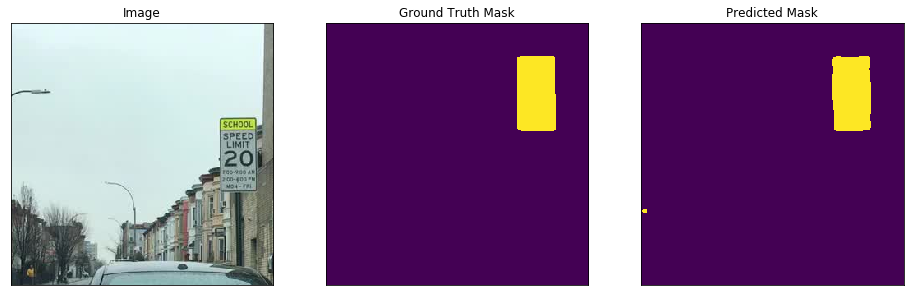

(320, 320)
(320,)


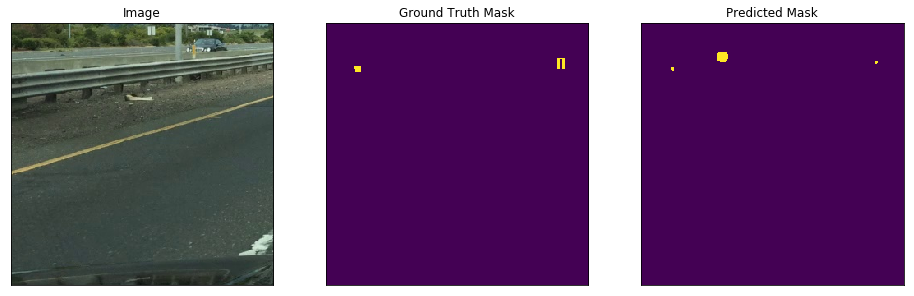

(320, 320)
(320,)


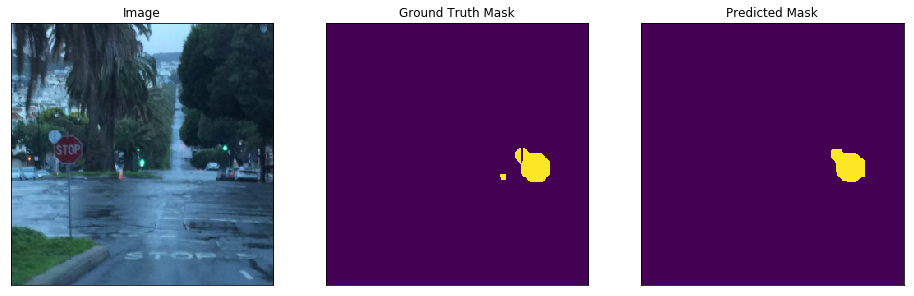

(320, 320)
(320,)


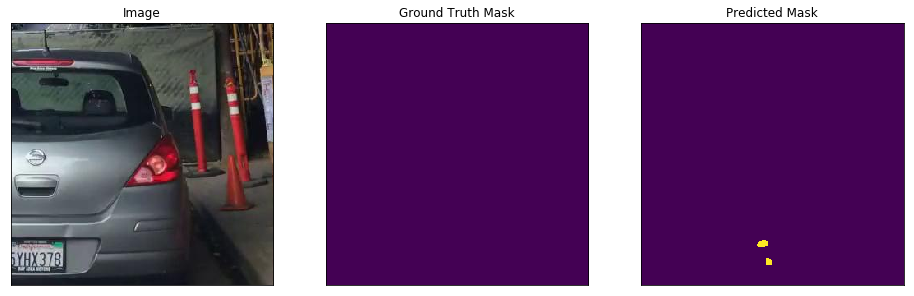

In [27]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print(gt_mask.shape)
    print(pr_mask[0].shape)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )